### Calculando a similaridade das frases de pacientes com o mapa de conhecimento

In [1]:
import numpy as np
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
#!python -m spacy download pt_core_news_md

Importação do mapa de conhecimento.

In [3]:
df_conhecimento = pd.read_csv('mapa_conhecimento.csv')
df_conhecimento.head()

,sintoma,diagnostico
0,Dor forte ou pressão intensa no peito,Infarto
1,"Dor forte no tórax, suor frio repentino",Infarto
2,Dor forte ou aperto no coração,Infarto
3,Falta de ar súbita,Infarto
4,Náusea ou vômito associado a dor,Infarto


Importação das frases de sintomas de pacientes.

In [4]:
df_sintomas = pd.read_csv('../dataset/sintomas_doencas_cardiacas.csv')
df_sintomas.head()

,frase,diagnostico,risco
0,Sinto uma dor aguda no peito que surge ao subi...,Angina,Baixo Risco
1,"Há dois dias, dor forte no peito irradia para ...",Infarto,Alto Risco
2,"Estou exausto o dia todo, mesmo sem esforço, e...",Insuficiência Cardíaca,Baixo Risco
3,Meu coração acelera de repente durante reuniõe...,Arritmia,Alto Risco
4,"Pressão no peito ao estressar no trabalho, ali...",Angina,Baixo Risco


Importação do spaCy em português.

In [5]:
nlp = spacy.load("pt_core_news_md")

Função para calcular a similaridade utilizando spaCy.

In [6]:
def calculate_similarity(texto1, texto2):
    doc1 = nlp(texto1)
    doc2 = nlp(texto2)
    return doc1.similarity(doc2)

Função para realizar o pré-processamento dos textos.

In [7]:
def text_processing(txt: str):
    """_summary_

    Args:
        txt (str): Texto a ser processado
        
    - Normaliza para minúsculas.
    - Remove stopwords, pontuações, acentuações e digítos numéricos.
    - Padroniza as palavras com a Lematização.
    """
    txt = txt.lower()
    doc = nlp(txt)
    
    words: list[str] = []
    
    for token in doc:
        if not token.is_stop and not token.is_punct and token.is_alpha:
            words.append(token.lemma_)
    
    words = ' '.join(unidecode(word) for word in words)
    return words

Realiza o pré-processamento para o dataset de sintomas e mapa de conhecimento.

In [8]:
df_sintomas['frase_processada'] = df_sintomas['frase'].apply(text_processing)
df_conhecimento['sintoma_processado'] = df_conhecimento['sintoma'].apply(text_processing)

### Teste com frases do dataset

In [9]:
calculate_similarity(df_sintomas.loc[0, 'frase_processada'], df_conhecimento.loc[0, 'sintoma_processado'])

0.766546368598938

Testa frases de pacientes com todos os sintomas presentes no `mapa_conhecimento.csv`. A frase com maior similaridade será o possível diagnóstico.

In [10]:
predictions = []
for _, row in df_sintomas.iterrows():
    frase_paciente = row['frase_processada']
    best_match = None
    symptom_true = None
    highest_similarity = 0.0
    
    for _, conhecimento in df_conhecimento.iterrows():
        sintoma = conhecimento['sintoma_processado']
        similarity = calculate_similarity(frase_paciente, sintoma)
        
        if similarity > highest_similarity:
            highest_similarity = similarity
            best_match = conhecimento['diagnostico']
            symptom_true = row['diagnostico']
    predictions.append((frase_paciente, best_match, symptom_true, highest_similarity))


In [11]:
df_predictions = pd.DataFrame(predictions, columns=['frase', 'diagnostico_predito', 'diagnostico_real', 'similaridade'])
df_predictions.head()

,frase,diagnostico_predito,diagnostico_real,similaridade
0,sinto dor agudo peito surgir subir escada dura...,Arritmia,Angina,0.811854
1,haver dia dor forte peito irradio braco esquer...,Infarto,Infarto,0.836447
2,exausto dia esforco incho pe noite,Insuficiência Cardíaca,Insuficiência Cardíaca,0.431676
3,coracao acelerar repente durante reuniao sensa...,Arritmia,Arritmia,0.701287
4,pressao peito estressar trabalho aliviar sentar,Angina,Angina,0.798811


### Avaliação do método de verificação de similaridade das frases

In [12]:
labels = np.unique(df_conhecimento['diagnostico'])
y_true, y_pred = df_sintomas['diagnostico'], df_predictions['diagnostico_predito']

In [13]:
acc = accuracy_score(y_true, y_pred)
print(f"Acurácia de {acc*100:.2f} %")

Acurácia de 53.00 %


In [14]:
print(classification_report(y_true, y_pred))

                        precision    recall  f1-score   support

                Angina       0.40      0.62      0.48        26
              Arritmia       0.52      0.60      0.56        25
               Infarto       0.82      0.54      0.65        26
Insuficiência Cardíaca       0.57      0.35      0.43        23

              accuracy                           0.53       100
             macro avg       0.58      0.53      0.53       100
          weighted avg       0.58      0.53      0.53       100



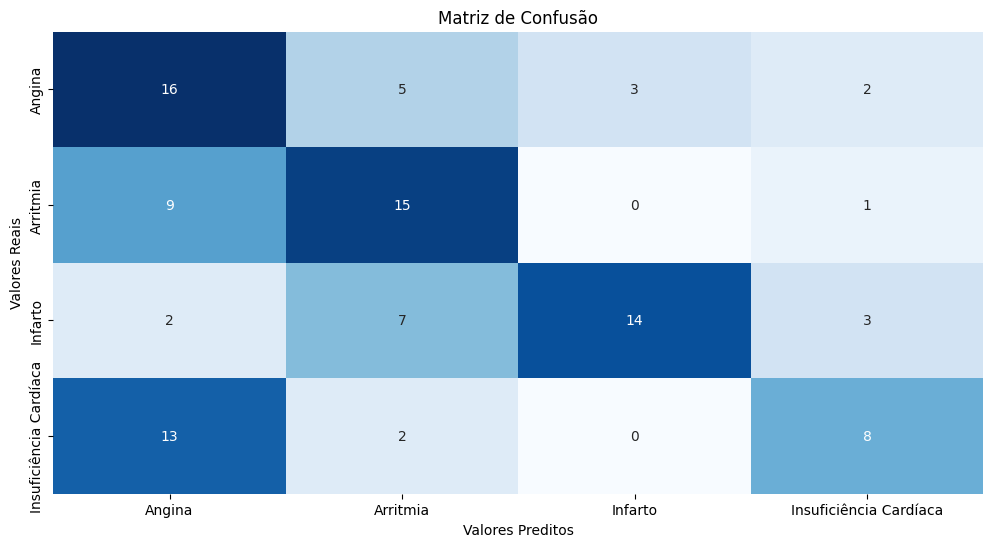

In [15]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

### Conclusão

Com este teste de semelhança entre as frases de sintomas de pacientes com as palavras e expressões do mapa de conhecimento não foi possível ter uma pontuação equivalente ao modelo de diagnóstico, porém, este caso de uso da ferramenta spaCy para tentar diagnosticar as doenças baseado nas similaridades entre as frases e expressões ainda se mostra muito interessante para situações onde há um mapa de conhecimento que represente com mais exatidão as palavras/expressões chaves para cada doença.